<a href="https://colab.research.google.com/github/Somani-Harsh/data-science-python/blob/master/Analysis_and_activity_prediction_model_for_mobile_app_user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [714]:
import pandas as pd
import numpy as np
import io
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from collections import Counter

**Read File and Preprocess**

In [6]:
master_df = pd.read_excel("/content/drive/My Drive/interviews/square panda/DataTest_Question1.xlsx")

In [7]:
master_df.keys()

Index(['id', 'childid', 'endtime', 'gamename', 'gamescore', 'nonsensewords',
       'starttime', 'userid', 'word', 'wordtype', 'createdat', 'end_ms_time',
       'start_ms_time', 'platform', 'dnc', 'gender', 'dateofbirth',
       'duration'],
      dtype='object')

In [838]:
master_df.head()

,id,childid,endtime,gamename,gamescore,nonsensewords,starttime,userid,word,wordtype,createdat,end_ms_time,start_ms_time,platform,dnc,gender,dateofbirth,duration
0,57830938206ac2317f5a957b,149,1.468206e+09,Bowling,1.0,False,1.468206e+09,11,POD,WORD,2016-07-11 02:49:28.421,NaN,NaN,NaN,1.0,M,2014-07-06 00:00:00,23.0
1,57848a78f3a1395b14b2b463,150,1.468304e+09,Bowling,1.0,False,1.468304e+09,11,SUM,WORD,2016-07-12 06:13:12.252,NaN,NaN,NaN,1.0,F,2011-07-06 00:00:00,21.0
2,57854751bada44451d58ae0e,943,1.468353e+09,Bowling,1.0,False,1.468353e+09,279,BOX,WORD,2016-07-12 19:38:57.303,NaN,NaN,NaN,1.0,O,2015-05-28 00:00:00,18.0
3,578874d5515961826c267444,186,1.468215e+09,Lagoon,1.0,False,1.468215e+09,18,RAM,WORD,2016-07-15 05:29:57.875,NaN,NaN,NaN,1.0,F,1992-05-12 00:00:00,1.0
4,5789811d515961826c267908,196,1.468629e+09,Bowling,1.0,False,1.468629e+09,69,BIG,WORD,2016-07-16 00:34:37.138,NaN,NaN,NaN,0.0,F,2012-12-17 00:00:00,53.0


Data Preprocessing & Filteration

In [839]:
print(master_df.shape)
df = master_df[~master_df["dnc"].isna()]
print(df.shape)
df = df[df["dnc"]==0]
df = df[df.apply(lambda x : x["endtime"] >= x["starttime"], axis=1)]
print(df.shape)

(309625, 18)
(309603, 18)
(228120, 18)


In [840]:
df.sort_values("starttime", inplace=True)

In [841]:
df["year_month"] = df["createdat"].apply(lambda x: x.year * 100 + x.month)
df["year_month_day"] = df["createdat"].apply(lambda x: (x.year * 100 + x.month)*100 + x.day)

max_start_date = df["createdat"].max().date() 
df["age"] = df["dateofbirth"].apply(lambda x: int((max_start_date - x.date()).days / 365) if not pd.isnull(x) else -1)
df["age_when_registered"] = df.apply(lambda x: int((x["createdat"] - x["dateofbirth"]).days / 365) \
                                                if not pd.isnull(x["dateofbirth"]) else -1, axis=1)

Filtering rows where age when registered is less than 1 year while keeping rows where date of birth is not mentioned

In [844]:
df = df[df["age_when_registered"].apply(lambda x : (x>1) or (x<0))]
print(df.shape)

(219121, 23)


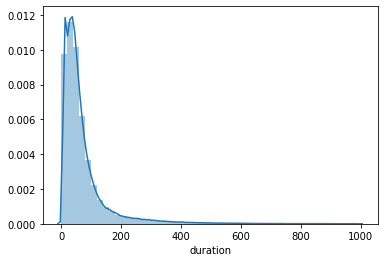

In [845]:
sns.distplot(df[df["duration"] < 1000]["duration"])

Filtering rows where duration is more than 10 mintues (600 seconds)

In [846]:
df = df[df["duration"]<=600]
df = df[df["duration"]>=0]
df.shape

(216713, 23)

**1) Sessions**

In [847]:
def get_time_difference_between_events(df):
  df["between_event_duration"] = df["endtime"] - df["starttime"].shift()
  return df

def label_sessions(df, time_lag_in_minutes):
    df["new_session"] = df["between_event_duration"] > time_lag_in_minutes * 60
    df["session_id"] = df["new_session"].cumsum()
    return df

In [848]:
df = df.groupby("userid").apply(get_time_difference_between_events)

In [849]:
temp_df = df[df[ "between_event_duration"] < 20000]["between_event_duration"]

In [850]:
gm = GaussianMixture(n_components=2)
gm.fit(np.array(temp_df[temp_df>0]).reshape(-1, 1))
gm.means_, gm.covariances_

(array([[ 114.14835565],
        [1780.33593471]]), array([[[6.70234008e+03]],
 
        [[1.00693718e+07]]]))

1(a) Session-ize the activities

Taking average session time 1780 seconds ~ 30 mintues

In [851]:
df = df.groupby("userid").apply(lambda x: label_sessions(x, 30))

In [852]:
df["user_session"] = df.apply(lambda x: str(x["userid"]) + "s" + str(x["session_id"]), axis=1)

1(b) Activity per session

In [853]:
user_session_df = df.groupby(["year_month", "user_session"])["userid"].apply(np.count_nonzero).reset_index()

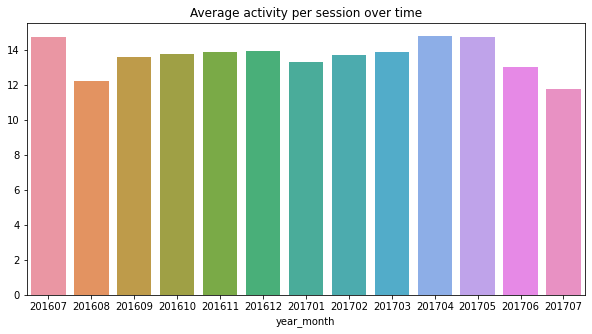

In [854]:
plt.figure(figsize=(10,5))
average_activity_per_sessions = user_session_df.groupby(["year_month"])["userid"].apply(np.average)
average_activity_per_sessions.name = "activity per session"
ax = sns.barplot(x=average_activity_per_sessions.index, y=average_activity_per_sessions.values)
_ = ax.set_title("Average activity per session over time")

 .

1(c) Count of games children play per session

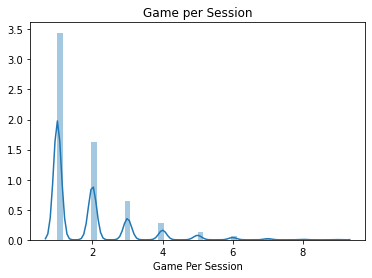

In [855]:
game_per_session = df.groupby(["user_session"])["gamename"].apply(set).apply(len)
game_per_session.name = "Game Per Session"
ax = sns.distplot(game_per_session)
_ = ax.set_title("Game per Session")

.

**2) Retention**

In [868]:
time_spent_on_activity_session = df.groupby(["year_month_day","childid", "user_session"]).apply(lambda x: x["endtime"].max() - x["starttime"].min()).reset_index()
time_spent_on_activity_daily = time_spent_on_activity_session.groupby(["year_month_day","childid"])[0].apply(np.sum)

In [869]:
# time_spent_on_activity_daily[time_spent_on_activity_daily==time_spent_on_activity_daily.max()]

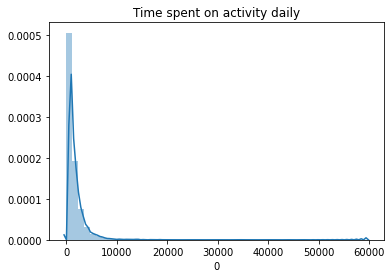

In [870]:
ax = sns.distplot(time_spent_on_activity_daily)
_ = ax.set_title("Time spent on activity daily")
# ax.set_xscale("log")

2(a) Activity time per day

In [879]:
print("Mean:",round(time_spent_on_activity_daily.mean() / 60, 2), "mintues")
print("Deviation:", round(time_spent_on_activity_daily.std() /60, 2), "minutes")

Mean: 24.1 mintues
Deviation: 30.16 minutes


.


2(b) Player Lifetime

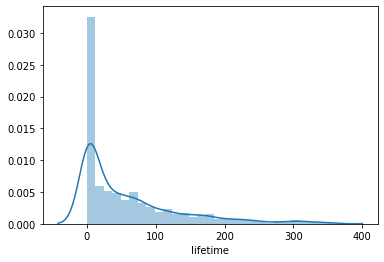

In [872]:
lifetime = df.groupby(["childid"]).apply(lambda x: np.ceil((x["endtime"].max() - x["starttime"].min()) / (24*3600)))
lifetime.name = "lifetime"
sns.distplot(lifetime)

In [873]:
print("Mean:",np.round(lifetime.mean(),2), "days")
print("Deviation:", np.round(lifetime.std(),2), "days")

Mean: 59.56 days
Deviation: 75.47 days


.


2(c) Games children play

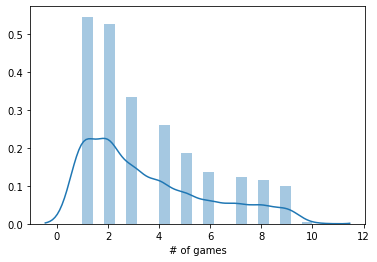

In [880]:
s = df.groupby("childid")["gamename"].apply(set).apply(len)
s.name = "# of games"
sns.distplot(s)

**Children plays other games as well**

In [875]:
def get_other_games(s):
  first = s.iloc[0]
  return list(set(s) - set([first]))

other_games = df.groupby(["user_session","childid"])["gamename"].apply(get_other_games).tolist()
print("Other Games that children plays in same session")
Counter(sum(other_games, [])).most_common()

Other Games that children plays in same session


[('Lagoon', 2371),
 ('Bowling', 2309),
 ('Letter Fishing', 1323),
 ('Farming', 1257),
 ('Letterlab', 1149),
 ('Bubbles', 1140),
 ('Space Cows', 992),
 ('Monster Rhymes', 714),
 ('Jiggity Jamble', 423),
 ('Letter Lullaby', 10)]

.


2(d) Duration of 1st game vs others in session

In [876]:
def compute(df):
    first_game = df["gamename"].iloc[0]
    first_game_duration = df[df["gamename"] == first_game]["duration"].sum()
    total_duration = df["duration"].sum()
    return first_game_duration * 100 / total_duration

In [877]:
first_game_duration_percent = df.groupby(["user_session", "childid"]).apply(compute)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


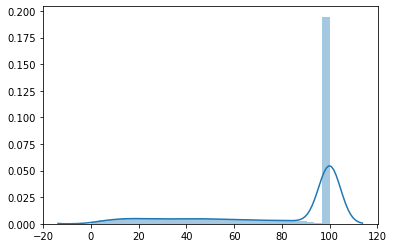

In [878]:
sns.distplot(first_game_duration_percent)

Children spent more time on the game they started with




.

Feature Generation

In [752]:
max_start_date_global = df["createdat"].max()
max_start_date_global

Timestamp('2017-07-14 05:01:53.330000')

In [857]:
def filter_recent_data(df, n_days=7):
  date_threshold = (max_start_date_global - datetime.timedelta(days=n_days)).date()
  return df[df["createdat"].dt.date < date_threshold]

def input_data(df, n_days=7):
  df_train = filter_recent_data(df, n_days=n_days)  
  df_test = df[~df.index.isin(df_train.index)]
  return df_train, df_test

def engagement_index(df, max_start_date):
  user_start_date = df["createdat"].min().date()
  user_last_date = df["createdat"].max().date()
  return (user_last_date - user_start_date + datetime.timedelta(1))/((max_start_date - user_start_date + datetime.timedelta(1)))
 

def generate_features(df, max_start_date):
  s = pd.Series()
  s["engagement_score"] = engagement_index(df, max_start_date)
  s["days_after_last_access"] = (max_start_date - df["createdat"].max().date()).days
  s["day_since_first_access"] = (max_start_date - df["createdat"].min().date()).days
  s["n_games_played"] = df["gamename"].nunique()
  s["duration_sum"] = df["duration"].sum()
  s["duration_mean"] = df["duration"].mean()
  s["active_last_7_days"] = s["days_after_last_access"] < 7
  s["active_last_30_days"] = s["days_after_last_access"] < 30
  s["n_played_days"] = df["createdat"].dt.date.nunique()
  s["n_sessions"] = df["user_session"].nunique()
  
  try:
    s["age_of_child"] = int((max_start_date - df["dateofbirth"].iloc[0].date()).days / 365)
  except:
    s["age_of_child"] = -1 

  s["platform"] = df["platform_"].iloc[-1]
  s["gender"] = df["gender_"].iloc[0]
  
  return s



In [858]:
df["gender_"] = df["gender"].astype("category").cat.codes
df["platform_"] = df["platform"].astype("category").cat.codes

In [860]:
# train data
interval_days = 7
n_days = interval_days * 2

x = []
y = []
for i in range(5):
  df1, df2 = input_data(df, n_days=n_days+(i*interval_days))
  max_start_date = df1["createdat"].max().date()
  print(max_start_date)
  active_childs = df2[df2["createdat"].dt.date < max_start_date + datetime.timedelta(interval_days)]["childid"].unique()
  grouped_df2 = df1.groupby("childid").apply(generate_features, max_start_date)
  grouped_df2["active"] = grouped_df2.index.isin(active_childs) * 1
  x.append(grouped_df2[["engagement_score", "days_after_last_access", "day_since_first_access", "age_of_child",
                        "n_games_played", "duration_sum", "duration_mean", "platform", "gender", "active_last_7_days", 
                  "active_last_30_days", "n_played_days", "n_sessions"]].values)
  y.append(grouped_df2["active"].values)

x_train = np.concatenate(x)
y_train = np.concatenate(y)

x_train.shape, y_train.shape

2017-06-29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2017-06-22
2017-06-15
2017-06-08
2017-06-01


((12347, 13), (12347,))

In [861]:
# test data
x_test = []
y_test = []
for i in range(2):
  df1, df2 = input_data(df, n_days=(i+1)*interval_days)
  max_start_date = df1["createdat"].max().date()
  print(max_start_date)
  active_childs = df2[df2["createdat"].dt.date < max_start_date + datetime.timedelta(interval_days)]["childid"].unique()
  grouped_df2 = df1.groupby("childid").apply(generate_features, max_start_date)
  grouped_df2["active"] = grouped_df2.index.isin(active_childs) * 1
  x_test.append(grouped_df2[["engagement_score", "days_after_last_access", "day_since_first_access", "age_of_child",
                             "n_games_played", "duration_sum", "duration_mean", "platform", "gender", "active_last_7_days",
                             "active_last_30_days", "n_played_days", "n_sessions"]].values)
  y_test.append(grouped_df2["active"].values)

x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

x_test.shape, y_test.shape

2017-07-06


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2017-06-29


((5223, 13), (5223,))

In [862]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc 

In [863]:
clf =  RandomForestClassifier(n_estimators=100, class_weight={0:1,1:5})
clf.fit(x_train, y_train)
clf.feature_importances_

array([0.13400314, 0.15692339, 0.14224185, 0.06077487, 0.05253246,
       0.11508169, 0.09484232, 0.02076367, 0.02372755, 0.05494473,
       0.0323925 , 0.04993538, 0.06183646])

**Prediction**

In [864]:
y_pred = clf.predict_proba(x_test)

Precision-Recall Curve

AUC PR Curve: 0.7465355601039237


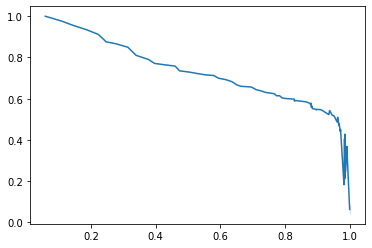

In [865]:
precision, recall, _ = precision_recall_curve(y_test, y_pred[:,1])
print("AUC PR Curve:", auc(recall, precision))
_ = sns.lineplot(precision, recall)

**Result: Classifier has PR AUC score of 0.74**


In [867]:
threshold = 0.1
print("threshold: ", threshold)
print(classification_report(y_test, (y_pred[:,1] > threshold) * 1))
print("\n\n")
threshold = 0.05
print("threshold: ", threshold)
print(classification_report(y_test, (y_pred[:,1] > threshold) * 1))

threshold:  0.1
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4917
           1       0.43      0.76      0.55       306

    accuracy                           0.93      5223
   macro avg       0.71      0.85      0.75      5223
weighted avg       0.95      0.93      0.94      5223




threshold:  0.05
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      4917
           1       0.28      0.87      0.42       306

    accuracy                           0.86      5223
   macro avg       0.63      0.86      0.67      5223
weighted avg       0.95      0.86      0.89      5223



.

**8 (b)** Likelihood of whether a child would play games will be more accurate for model which will be predicting likelihood of event in the next 30 days